In [ ]:
#!pip install tensorflow

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
print("Done")

Done


In [ ]:
train_directory = './chest_xray/train'
val_directory = './chest_xray/val'
test_directory = './chest_xray/test'

In [95]:
height = 224
width = 224
batch_size = 32

In [96]:
EPOCHS = 50

In [97]:
# data augmentation and preprocessing for the training set  
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

# preprocessing of the val set
val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# preprocessing of the test set
test_data_generator= tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [98]:
train_data = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(height, width),
    class_mode='binary',
    batch_size=batch_size
)


test_data = train_data_generator.flow_from_directory(
    test_directory,
    target_size=(height, width),
    class_mode='binary',
    batch_size=batch_size
)

val_data = train_data_generator.flow_from_directory(
    val_directory,
    target_size=(height, width),
    class_mode='binary',
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [99]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [100]:
mobilenetv2.trainable = False

In [101]:
inputs = tf.keras.Input(shape=(height, width, 3))
pretrained_model = mobilenetv2(inputs, training=False)
dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs, outputs)


In [102]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [103]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [104]:
# training the model with early stopping to prevent overfitting
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=batch_size,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 778ms/step - accuracy: 0.8967 - auc: 0.9156 - loss: 0.3095 - val_accuracy: 0.9375 - val_auc: 0.9844 - val_loss: 0.2338
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 769ms/step - accuracy: 0.9601 - auc: 0.9909 - loss: 0.1071 - val_accuracy: 0.6875 - val_auc: 0.9375 - val_loss: 0.6721
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 831ms/step - accuracy: 0.9527 - auc: 0.9884 - loss: 0.1193 - val_accuracy: 0.8125 - val_auc: 0.9688 - val_loss: 0.3062
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 785ms/step - accuracy: 0.9677 - auc: 0.9943 - loss: 0.0825 - val_accuracy: 0.6875 - val_auc: 0.9688 - val_loss: 0.8439


In [105]:
confusion_matrix = confusion_matrix(test_data.labels, np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int64)))


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 791ms/step


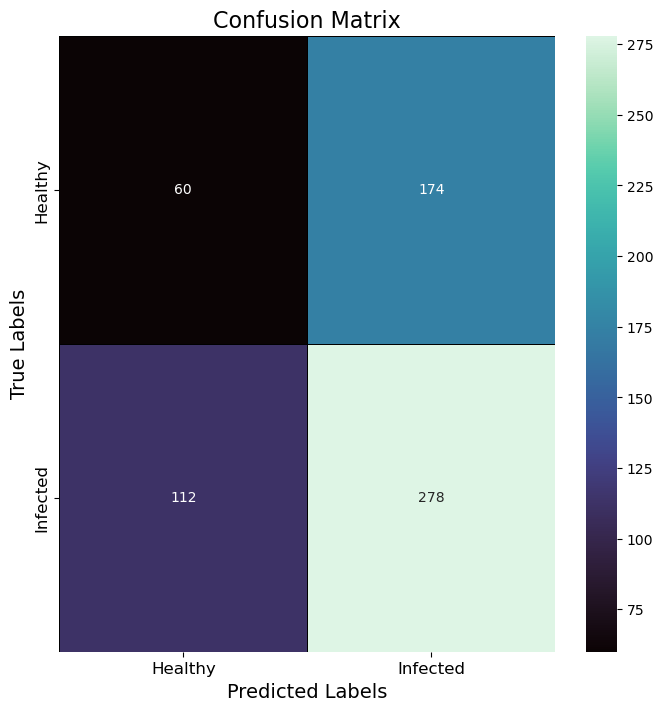

In [106]:
# plotting the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='mako', cbar=True, linewidths=0.5, linecolor='black')
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(np.arange(2) + 0.5, ['Healthy', 'Infected'], fontsize=12)
plt.yticks(np.arange(2) + 0.5, ['Healthy', 'Infected'], fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [107]:
evaluation_metrics = model.evaluate(test_data) 
# storing the evaluation metrics after evaluating the model using the test dataset

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 721ms/step - accuracy: 0.8606 - auc: 0.9491 - loss: 0.3526


In [108]:
accuracy = evaluation_metrics[1]
auc = evaluation_metrics[2]

tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.87
AUC: 0.95
Precision: 0.62
Recall: 0.71


In [ ]:
# plotting these values 

In [116]:
metrics_names = ['Accuracy', 'AUC', 'Precision', 'Recall']
values = [accuracy, auc, precision, recall]

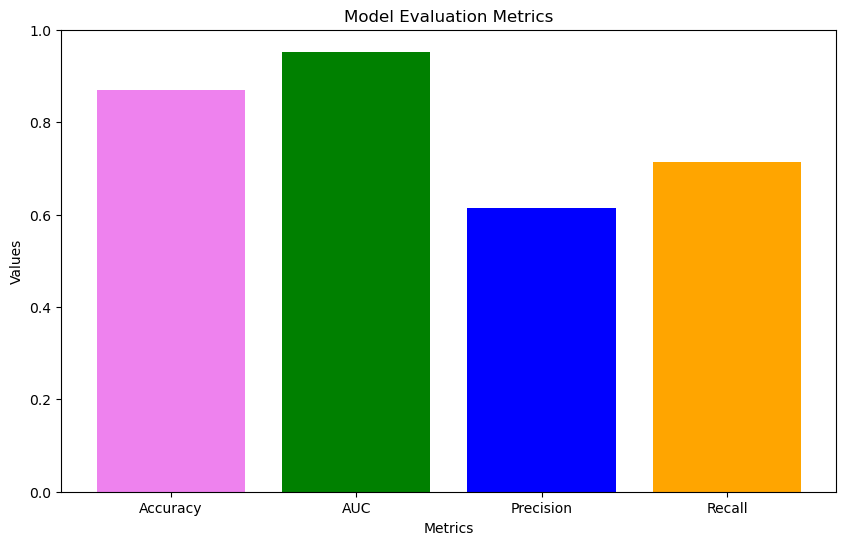

In [126]:
# use a barplot to plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, values, color=['violet', 'green', 'blue', 'orange'])
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1) 
plt.show()

In [131]:
model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 698ms/step - accuracy: 0.8660 - auc: 0.9508 - loss: 0.3295


[0.34917151927948, 0.8685897588729858, 0.9477317333221436]

In [ ]:
# save model as a HDF5 file
# model.save("")  # between "", add the path to the folder you want to save the model in, choose a name for the model then add the extension .h5

In [ ]:
# save model as a keras file (native Keras format)
# model.save("")  # between "", add the path to the folder you want to save the model in, choose a name for the model then add the extension .keras

In [ ]:
# the following cells contain ways to take different types of input data and make predictions based on them

In [ ]:
val_data.reset()

filenames = val_data.filenames # filenames of the validation data
num_samples = len(filenames)
steps = int(np.ceil(num_samples / batch_size))


predictions = model.predict(val_data, steps=steps) # predict the classes of the validaton data
predicted_classes = (predictions > 0.5).astype("int32") # converting predictions to class labels (0 or 1)

# going through each file and checking the corrresponding prediction
for i in range(num_samples):
    print(f"Filename: {filenames[i]}, Prediction: {predicted_classes[i][0]}")


In [133]:
true_classes = val_data.classes
print(true_classes)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


In [134]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [ ]:
# predicting an image from a folder 
# img_path = '' # introduce the path to the image here
preprocessed_image = preprocess_image(img_path)
prediction = model.predict(preprocessed_image)
predicted_class = (prediction > 0.5).astype("int32")[0][0]
class_names = ['NORMAL', 'PNEUMONIA']
predicted_class_name = class_names[predicted_class]

print(f"Prediction: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
Prediction: PNEUMONIA


In [136]:
import os

def predict_folder(folder_path): # predicts the class from each image from a given folder
    class_names = ['NORMAL', 'PNEUMONIA']

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            preprocessed_image = preprocess_image(img_path)
            
            # predicting the class of the image
            prediction = model.predict(preprocessed_image)
            predicted_class = (prediction > 0.5).astype("int32")[0][0]
            predicted_class_name = class_names[predicted_class]
            
            print(f"Filename: {filename}, Prediction: {predicted_class_name}")
